<a href="https://colab.research.google.com/github/anshkumar/elf/blob/master/CHSO_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!cp "./drive/My Drive/data.zip" .

In [3]:
!unzip ./data.zip

Archive:  ./data.zip
replace data/VIC/PRICE_AND_DEMAND_201501_VIC1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
class sw(object):

    def __init__(self):

        self.__Positions = []
        self.__Gbest = []

    def _set_Gbest(self, Gbest):
        self.__Gbest = Gbest

    def _points(self, agents):
        self.__Positions.append([list(i) for i in agents])

    def get_agents(self):
        """Returns a history of all agents of the algorithm (return type:
        list)"""

        return self.__Positions

    def get_Gbest(self):
        """Return the best position of algorithm (return type: list)"""

        return list(self.__Gbest)


In [0]:
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 25 15:16:25 2018

@author: vedanshu
"""

import numpy as np
from math import gamma, pi, sin, sqrt
from random import normalvariate, randint, random
from math import ceil, exp
from random import choice, shuffle

class QuadraticCost(object):
    @staticmethod
    def fn(a,y):
        return 0.5*np.linalg.norm(a-y)**2
        
    @staticmethod
    def delta(activation, z, a, y):
        if(activation == Activation.sigmoid):
            return (a-y)*Activation.sigmoid_prime(z)
        elif(activation == Activation.tanh):
            return (a-y)*Activation.tanh_prime(z)
        elif(activation == Activation.relu):
            return (a-y)*(z > 0)
        
class Accuracy(object):
    @staticmethod
    def mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    @staticmethod
    def rmse(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_true - y_pred))) 
 
    @staticmethod
    def mae(y_true, y_pred):
        return np.mean(np.abs(y_true - y_pred))

class CrossEntropyCost(object):
    @staticmethod
    def fn(a, y):
        a[a == 0] = 1e-10
        return np.sum(np.nan_to_num(-y*np.log(a) - (1-y)*np.log(1-a)))
    
    @staticmethod
    def delta(activation, z, a, y):
        if(activation == Activation.sigmoid):
            return a-y
        else:
            return (a - y + 1 - y/a)
        
class Activation(object):
    @staticmethod
    def sigmoid(z):
        return 1.0/(1.0 + np.exp(-z))
    
    @staticmethod
    def sigmoid_prime(z):
        return Activation.sigmoid(z)*(1 - Activation.sigmoid(z))

    @staticmethod        
    def tanh(z):
        return 2*Activation.sigmoid(2*z) - 1
    
    @staticmethod        
    def tanh_prime(z):
        return 1 - (Activation.tanh(z))**2
        
    @staticmethod
    def relu(z):
        return z * (z > 0)

class Network(sw):
    def __init__(self, sizes, activate, cost = CrossEntropyCost):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost = cost
        self.activate = activate
        self.dim = sum(x*(y+1) for x,y in zip(self.sizes[1:], self.sizes[:-1]))
               
    def default_weight_initializer(self):
        self.biases = [np.random.randn(x,1) for x in self.sizes[1:]]
        self.weights = [np.random.randn(x,y)/np.sqrt(x) 
                        for x,y in zip(self.sizes[1:], self.sizes[:-1])]
    
    def large_weight_initializer(self):
        self.biases = [np.random.randn(x,1) for x in self.sizes[1:]]
        self.weights = [np.random.randn(x,y) 
                        for x,y in zip(self.sizes[1:], self.sizes[:-1])]
    
    def feedforward(self,a):
        for b,w in zip(self.biases, self.weights):
            a  = (self.activate)(np.matmul(w,a) + b)
        return a
                
    def set_weight_bias(self, a):
        lIt = 0
        rIt = 0
        self.weights = []
        self.biases = []
        for x,y in zip(self.sizes[1:], self.sizes[:-1]):
            rIt += x*y
            self.weights.append(a[lIt:rIt].reshape((x,y)))
            lIt = rIt
        for x in self.sizes[1:]:
            rIt += x
            self.biases.append(a[lIt:rIt].reshape((x,1)))
            lIt = rIt
           
    def SGD(self, train_x, train_y, epochs, mini_batch_size, eta,
            evaluation_x = None, evaluation_y = None, lmbda = 0.0,
            monitor_evaluation_cost = False,
            monitor_evaluation_accuracy = False,
            monitor_training_cost = False,
            monitor_training_accuracy = False,
            output2D = False):
   
        evaluation_cost, eval_mape, eval_rmse, eval_mae = [], [] , [] , []
        training_cost, training_mape, training_rmse, training_mae = [], [] , [] , []
        n_train = train_x.shape[1]
        for i in range(epochs): 
            for j in range(0, int(n_train/mini_batch_size)):
                #taking transpose below in very much important
                X = train_x[:,j*mini_batch_size:(j+1)*mini_batch_size]
                if output2D:
                    y = train_y[:, j*mini_batch_size:(j+1)*mini_batch_size]
                else:
                    y = train_y[j*mini_batch_size:(j+1)*mini_batch_size]
                self.update_mini_batch(X, y, mini_batch_size, eta, lmbda, train_x.shape[1])
                               
            if i % 100 == 0:
                print("Epochs {0}".format(i))
            if monitor_training_cost:
                cost = self.total_cost(train_x, train_y, lmbda, output2D)
                training_cost.append(cost)
                if i % 100 == 0:
                    print("Cost on training data: {1}".format(i, cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(train_x, train_y, output2D, Accuracy.mape)
                training_mape.append(accuracy)
                if i % 100 == 0:
                    print("MAPE on training data: {0}".format(accuracy))
                    
                accuracy = self.accuracy(train_x, train_y, output2D, Accuracy.rmse)
                training_rmse.append(accuracy)
                if i % 100 == 0:
                    print("RMSE on training data: {0}".format(accuracy))
                    
                accuracy = self.accuracy(train_x, train_y, output2D, Accuracy.mae)
                training_mae.append(accuracy)
                if i % 100 == 0:
                    print("MAE on training data: {0}".format(accuracy))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_x, evaluation_y, lmbda, output2D)
                evaluation_cost.append(cost)
                if i % 100 == 0:
                    print("Cost on evaluation data: {1}".format(i, cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_x, evaluation_y, output2D, Accuracy.mape)
                eval_mape.append(accuracy)
                if i % 100 == 0:
                    print("MAPE on evaluation data: {0}".format(accuracy)) 
                    
                accuracy = self.accuracy(evaluation_x, evaluation_y, output2D, Accuracy.rmse)
                eval_rmse.append(accuracy)
                if i % 100 == 0:
                    print("RMSE on evaluation data: {0}".format(accuracy)) 
                    
                accuracy = self.accuracy(evaluation_x, evaluation_y, output2D, Accuracy.mae)
                eval_mae.append(accuracy)
                if i % 100 == 0:
                    print("MAE on evaluation data: {0}".format(accuracy)) 
        return evaluation_cost, eval_mape, eval_rmse, eval_mae, training_cost, training_mape, training_rmse, training_mae
    
    def update_mini_batch(self, X, y, mini_batch_size, eta, lmbda, n):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        delta_nabla_b, delta_nabla_w = self.backprop(X, y, mini_batch_size)
        nabla_b = [nb+dnb for nb,dnb in zip(nabla_b, delta_nabla_b)]
        nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
            
        self.biases = [b - (eta/mini_batch_size)*nb 
                            for b,nb in zip(self.biases, nabla_b)]


#       L2 regulrization        
#        self.weights = [(1 - eta*(lmbda/n))*w - (eta/mini_batch_size)*nw 
#                            for w,nw in zip(self.weights, nabla_w)]

#       L1 regulrization
        self.weights = [(w - eta*(lmbda/n)*np.sign(w)) - (eta/mini_batch_size)*nw 
                            for w,nw in zip(self.weights, nabla_w)]
                            
    def backprop(self, X, y, mini_batch_size):
        activations = [X]
        z = []
        delta = [np.zeros((x, mini_batch_size)) 
                        for x in self.sizes[1:]]
        delta_nabla_w = [np.zeros(w.shape) for w in self.weights]
        
        for b,w in zip(self.biases, self.weights):
            z.append(np.matmul(w,activations[-1]) + b)
            activations.append((self.activate)(z[-1]))
           
        delta[-1] = (self.cost).delta(self.activate, z[-1], activations[-1], y)
        delta_nabla_w[-1] = np.dot(delta[-1], activations[-2].transpose())
                        
        for l in range(2,self.num_layers):
            delta[-l] = np.dot(self.weights[-l + 1].transpose(), 
                                        delta[-l+1])*\
                                        (self.activate)(z[-l])
            delta_nabla_w[-l] = np.dot(delta[-l], 
                                        activations[-l-1].transpose())
        
        delta_nabla_b = [b.sum(axis = 1).reshape((b.shape[0], 1)) 
                        for b in delta]
        return (delta_nabla_b, delta_nabla_w)
        
    def accuracy(self, X, Y, output2D = False, AccFunc = Accuracy.mape):
        if not output2D:
            results = np.zeros(X.shape[1])
            for i in range(0, X.shape[1]):
                x = X[:, i]
                x = x.reshape((x.shape[0], 1))    #Very much important           
                results[i] = self.feedforward(x).item(0)
            return AccFunc(Y, results)
        else:
            results = []
            for i in range(0, X.shape[1]):
                x = X[:, i]
                x = x.reshape((x.shape[0], 1))    #Very much important           
                results.append(self.feedforward(x))
            return AccFunc(Y, np.hstack(results))
        
    def total_cost(self, X, Y, lmbda, output2D = False):
        cost = 0.0
        for j in range(0, int(X.shape[1])):
            x = X[:, j]
            if output2D:
                y = Y[:,j]
            else:
                y = Y[j]
            x = x.reshape((x.shape[0], 1))    #Very much important   
            a = self.feedforward(x)
            cost += self.cost.fn(a,y)/Y.shape[0]
        cost += 0.5*(lmbda/Y.shape[0])*sum(np.linalg.norm(w)**2 for w in self.weights)
        return cost     
        
    """
    Chicken Swarm Optimization
    """

    def multiObjectiveFunction(self,x):
        self.set_weight_bias(x)
        y_prime = self.feedforward(self.input)
        ob1 = sum(abs(u-v) for u,v in zip(y_prime, self.output))/x.shape[0]
        ob2 = sqrt(sum((u-v)**2 for u,v in zip(y_prime, self.output))/x.shape[0])
        ob3 = sum(abs((u-v)/v) for u,v in zip(y_prime, self.output))/x.shape[0]
        ob4 = sqrt(sum((abs((u-v)/v) - ob3)**2 for u,v in zip(y_prime, self.output))/x.shape[0])
        return min([ob1,ob2,ob3,ob4])
    
    def chso(self, n, x, y, function, lb, ub, dimension, iteration, G=5, FL=0.5):
        """
        :param n: number of agents
        :param function: test function
        :param lb: lower limits for plot axes
        :param ub: upper limits for plot axes
        :param dimension: space dimension
        :param iteration: number of iterations
        :param G: after what time relationship will be upgraded (default
        value is 5)
        :param FL: parameter, which means that the chick would follow its
        mother to forage for food (0 < FL < 2. Default value is 0.5)
        """

        super(Network, self).__init__()
        
        self.input = x
        self.output = y

        rn = ceil(0.15 * n)
        hn = ceil(0.7 * n)
        cn = n - rn - hn
        mn = ceil(0.2 * n)

        self.__agents = np.random.uniform(lb, ub, (n, dimension))
        pbest = self.__agents
        self._points(self.__agents)

        fitness = [function(x) for x in self.__agents]
        pfit = fitness

        Pbest = self.__agents[np.array(fitness).argmin()]
        Gbest = Pbest

        for t in range(iteration):

            if t % G == 0:

                chickens = self.__update_relationship(n, function, rn, hn,
                                                      cn, mn)
                roosters, hines, chicks = chickens

            for i in roosters:

                k = choice(roosters)
                while k == i:
                    k = choice(roosters)

                if pfit[i] <= pfit[k]:
                    sigma = 1
                else:
                    sigma = exp((pfit[k] - pfit[i]) / (abs(pfit[i]) + 0.01))

                self.__agents[i] = pbest[i] * (1 + np.random.normal(0, sigma,
                                                                    dimension))

            for i in hines:

                r1 = i[1]
                r2 = choice([choice(roosters), choice(hines)[0]])
                while r2 == r1:
                    r2 = choice([choice(roosters), choice(hines)[0]])

                s1 = exp((pfit[i[0]] - pfit[r1]) / (abs(pfit[i[0]]) + 0.01))

                try:
                    s2 = exp(pfit[r2] - pfit[i[0]])
                except OverflowError:
                    s2 = float('inf')

                rand1 = np.random.random((1, dimension))[0]
                rand2 = np.random.random((1, dimension))[0]

                self.__agents[i[0]] = pbest[i[0]] + s1 * rand1 * (
                    pbest[r1] - pbest[i[0]]) + s2 * rand2 * (
                    pbest[r2] - pbest[i[0]])

            for i in chicks:
                self.__agents[i[0]] = pbest[i[0]] * FL * (pbest[i[1]] -
                                                          pbest[i[0]])

            self.__kill(n, function, lb, ub, dimension)

            self.__agents = np.clip(self.__agents, lb, ub)
            self._points(self.__agents)

            fitness = [function(x) for x in self.__agents]

            for i in range(n):
                if fitness[i] < pfit[i]:
                    pfit[i] = fitness[i]
                    pbest[i] = self.__agents[i]

            Pbest = self.__agents[np.array(fitness).argmin()]
            if function(Pbest) < function(Gbest):
                Gbest = Pbest

        self._set_Gbest(Gbest)

    def __update_relationship(self, n, function, rn, hn, cn, mn):

        fitness = [(function(self.__agents[i]), i) for i in range(n)]
        fitness.sort()

        chickens = [i[1] for i in fitness]
        roosters = chickens[:rn]
        hines = chickens[rn:-cn]
        chicks = chickens[-cn:]

        shuffle(hines)
        mothers = hines[:mn]

        for i in range(cn):
            chicks[i] = chicks[i], choice(mothers)

        for i in range(hn):
            hines[i] = hines[i], choice(roosters)

        return roosters, hines, chicks

    def __kill(self, n, function, lb, ub, dimension):

        for i in range(n):

            fit = None

            try:
                fit = function(self.__agents[i])
            except OverflowError:
                for j in range(dimension):
                    self.__agents[i][j] = round(self.__agents[i][j])

            if str(fit) == 'nan':
                self.__agents[i] = np.random.uniform(lb, ub, (1, dimension))
                
                


In [0]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sun Jun 17 21:30:36 2018

@author: vedanshu
"""

"""
overfitting
~~~~~~~~~~~
Plot graphs to illustrate the problem of overfitting.  
"""

# Standard library
import json

# Third-party libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from os import path

def make_plots(filename, num_epochs, 
               training_cost_xmin=200, 
               test_accuracy_xmin=200, 
               test_cost_xmin=0, 
               training_accuracy_xmin=0,
               plt_training_cost = False,
               plt_training_accuracy = False,
               plt_test_cost = False,
               plt_test_accuracy = True,
               plt_overlay = False):
    """Load the results from ``filename``, and generate the corresponding
    plots. """
    f = open(filename, "r")
    test_cost, test_mape, test_rmse, test_mae, training_cost, training_mape, \
        training_rmse, training_mae = json.load(f)
    f.close()
    if plt_training_cost:
        plot_training_cost(training_cost, num_epochs, training_cost_xmin)
    if plt_test_accuracy:
        plot_test_accuracy(test_mape, num_epochs, test_accuracy_xmin)
    if plt_test_cost:
        plot_test_cost(test_cost, num_epochs, test_cost_xmin)
    if plt_training_accuracy:
        plot_training_accuracy(training_mape, num_epochs, 
                               training_accuracy_xmin)
    if plt_overlay:
        plot_overlay(test_mape, training_mape, num_epochs,
                 min(test_accuracy_xmin, training_accuracy_xmin))

def plot_training_cost(training_cost, num_epochs, training_cost_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(training_cost_xmin, num_epochs), 
            training_cost[training_cost_xmin:num_epochs],
            color='#2A6EA6')
    ax.set_xlim([training_cost_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Cost on the training data')
    plt.show()

def plot_test_accuracy(test_accuracy, num_epochs, test_accuracy_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(test_accuracy_xmin, num_epochs), 
            [accuracy
             for accuracy in test_accuracy[test_accuracy_xmin:num_epochs]],
            color='#2A6EA6')
    ax.set_xlim([test_accuracy_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Error on the test data')
    plt.show()

def plot_test_cost(test_cost, num_epochs, test_cost_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(test_cost_xmin, num_epochs), 
            test_cost[test_cost_xmin:num_epochs],
            color='#2A6EA6')
    ax.set_xlim([test_cost_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Cost on the test data')
    plt.show()

def plot_training_accuracy(training_accuracy, num_epochs, 
                           training_accuracy_xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(training_accuracy_xmin, num_epochs), 
            [accuracy 
             for accuracy in training_accuracy[training_accuracy_xmin:num_epochs]],
            color='#2A6EA6')
    ax.set_xlim([training_accuracy_xmin, num_epochs])
    ax.grid(True)
    ax.set_xlabel('Epoch')
    ax.set_title('Error on the training data')
    plt.show()

def plot_overlay(test_accuracy, training_accuracy, num_epochs, xmin):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(np.arange(xmin, num_epochs), 
            [accuracy for accuracy in test_accuracy], 
            color='#2A6EA6',
            label="Error on the test data")
    ax.plot(np.arange(xmin, num_epochs), 
            [accuracy 
             for accuracy in training_accuracy], 
            color='#FFA933',
            label="Error on the training data")
    ax.grid(True)
    ax.set_xlim([xmin, num_epochs])
    ax.set_xlabel('Epoch')
    ax.set_ylim([0, 20])
    plt.legend(loc="lower right")
    plt.show()

def timeSeriesSplit(cso = False):
    state = {0: 'NSW', 1: 'QLD', 2: 'SA', 3: 'TAS', 4: 'VIC'}
    year = {0: '2015', 1: '2016', 2: '2017'}
    
    df_nsw = pd.DataFrame()
    df_qld = pd.DataFrame()
    df_sa = pd.DataFrame()
    df_tas = pd.DataFrame()
    df_vic = pd.DataFrame()
    
    df = {'NSW': df_nsw, 'QLD': df_qld, 'SA': df_sa, 'TAS': df_tas, 'VIC': df_vic}
    
    df_nsw_test = pd.DataFrame()
    df_qld_test = pd.DataFrame()
    df_sa_test = pd.DataFrame()
    df_tas_test = pd.DataFrame()
    df_vic_test = pd.DataFrame()
    
    df_test = {'NSW': df_nsw_test, 'QLD': df_qld_test, 'SA': df_sa_test, 'TAS': df_tas_test, 'VIC': df_vic_test}
    
    for st in state.values():
        for ye in year.values():
            for mn in range(1,13):
                if mn < 10:            
                    dataset = pd.read_csv('./datasets/train/' + st + '/PRICE_AND_DEMAND_' + ye + '0' + str(mn) +'_' + st + '1.csv')
                else:
                    dataset = pd.read_csv('./datasets/train/' + st + '/PRICE_AND_DEMAND_' + ye + str(mn) +'_' + st + '1.csv')
                df[st] = df[st].append(dataset.iloc[:,1:3])
        df[st] = df[st].set_index('SETTLEMENTDATE')
       
    for st in state.values():
        dataset = pd.read_csv('./datasets/test/' + st + '/PRICE_AND_DEMAND_201801_' + st + '1.csv')
        df_test[st] = df_test[st].append(dataset.iloc[:,1:3])
        df_test[st] = df_test[st].set_index('SETTLEMENTDATE')
       
    # numpy array
    list_hourly_load_NSW = np.array(df['NSW'])
    list_hourly_load_QLD = np.array(df['QLD'])
    list_hourly_load_SA = np.array(df['SA'])
    list_hourly_load_TAS = np.array(df['TAS'])
    list_hourly_load_VIC = np.array(df['VIC'])
       
    # the length of the sequnce for predicting the future value
    sequence_length = 84
    x_size = 36
    hidden = 10
    y_size = 48
    
    # normalizing
    matrix_load_NSW = list_hourly_load_NSW / np.linalg.norm(list_hourly_load_NSW)
    matrix_load_QLD = list_hourly_load_QLD / np.linalg.norm(list_hourly_load_QLD)
    matrix_load_SA = list_hourly_load_SA / np.linalg.norm(list_hourly_load_SA)
    matrix_load_TAS = list_hourly_load_TAS / np.linalg.norm(list_hourly_load_TAS)
    matrix_load_VIC = list_hourly_load_VIC / np.linalg.norm(list_hourly_load_VIC)
    
    matrix_load_NSW = matrix_load_NSW[:-(len(matrix_load_NSW) % sequence_length)]
    matrix_load_QLD = matrix_load_QLD[:-(len(matrix_load_QLD) % sequence_length)]
    matrix_load_SA = matrix_load_SA[:-(len(matrix_load_SA) % sequence_length)]
    matrix_load_TAS = matrix_load_TAS[:-(len(matrix_load_TAS) % sequence_length)]
    matrix_load_VIC = matrix_load_VIC[:-(len(matrix_load_VIC) % sequence_length)]
    
    matrix_load_NSW = matrix_load_NSW.reshape(-1, sequence_length)
    matrix_load_QLD = matrix_load_QLD.reshape(-1, sequence_length)
    matrix_load_SA = matrix_load_SA.reshape(-1, sequence_length)
    matrix_load_TAS = matrix_load_TAS.reshape(-1, sequence_length)
    matrix_load_VIC = matrix_load_VIC.reshape(-1, sequence_length)
    
    # shuffle the training set (but do not shuffle the test set)
    np.random.shuffle(matrix_load_NSW)
    np.random.shuffle(matrix_load_QLD)
    np.random.shuffle(matrix_load_SA)
    np.random.shuffle(matrix_load_TAS)
    np.random.shuffle(matrix_load_VIC)
    
    # the training set
    X_NSW = matrix_load_NSW[:, :x_size]
    X_QLD = matrix_load_QLD[:, :x_size]
    X_SA = matrix_load_SA[:, :x_size]
    X_TAS = matrix_load_TAS[:, :x_size]
    X_VIC = matrix_load_VIC[:, :x_size]
    
    # the last column is the true value to compute the mean-squared-error loss
    y_NSW = matrix_load_NSW[:, x_size:]
    y_QLD = matrix_load_QLD[:, x_size:]
    y_SA = matrix_load_SA[:, x_size:]
    y_TAS = matrix_load_TAS[:, x_size:]
    y_VIC = matrix_load_VIC[:, x_size:]
    
    tscv = TimeSeriesSplit(n_splits=5)
    
    X = {'NSW': X_NSW, 'QLD': X_QLD, 'SA': X_SA, 'TAS': X_TAS, 'VIC': X_VIC}
    y = {'NSW': y_NSW, 'QLD': y_QLD, 'SA': y_SA, 'TAS': y_TAS, 'VIC': y_VIC}
    
    for st in state.values():
        print("State: ", st)
        i = 1
        for train_index, test_index in tscv.split(X[st]):
            X_train, X_test = X[st][train_index], X[st][test_index]
            y_train, y_test = y[st][train_index], y[st][test_index]
            
            print("Train and validation from state ", st, " split ", i)
            net = nt.Network([x_size, hidden, y_size], nt.Activation.tanh, nt.QuadraticCost)
            if cso:
                fname = "kernelBiasTimeSeries" + st + ".npy"
                if not path.exists(fname):
                    print("Weights and biases initialization for state ",st, " in progress...")
                    randInt = np.random.randint(X_train.shape[0])
                    net.cso(100,X_train[randInt].reshape(x_size,1),y_train[randInt].reshape(y_size,1),
                                net.multiObjectiveFunction,-0.6,0.6,net.dim ,100)
                    net.set_weight_bias(np.array(net.get_Gbest()))
                    np.save(fname, np.array(net.get_Gbest()))
                net.set_weight_bias(np.load(fname))

            if cso:
                fname = "results_" + st + "_TS_" + str(i) + "CSO"
            else:
                fname = "results_" + st + "_TS_" + str(i) + "GD"
            num_epochs = 1500
            lmbda = 2
            
            evaluation_cost, eval_mape, eval_rmse, eval_mae, training_cost, training_mape, training_rmse, training_mae = net.SGD(
                    X_train.transpose(),y_train.transpose(), num_epochs, 
                    10, 0.01, 
                    X_test.transpose(), y_test.transpose(), 
                    lmbda, monitor_evaluation_cost = True,
                    monitor_evaluation_accuracy = True,
                    monitor_training_cost = True,
                    monitor_training_accuracy = True,
                    output2D = True)
            
            f = open(fname, "w")
            json.dump([evaluation_cost, eval_mape, eval_rmse, eval_mae, training_cost, training_mape, training_rmse, training_mae], f)
            f.close()
                
#            make_plots(fname, num_epochs,
#                       training_cost_xmin = 0,
#                       test_accuracy_xmin = 0,
#                       test_cost_xmin = 0, 
#                       training_accuracy_xmin = 0)
            i = i+1

def fiveFoldCrossValidation(cso = False):
    #State and year to use for training and testing
    state = {0: 'NSW', 1: 'QLD', 2: 'SA', 3: 'TAS', 4: 'VIC'}
#    state = {0: 'NSW'}
    year = {0: '2015', 1: '2016', 2: '2017'}
#    year = {0: '2015'}
    
    hidden = 10
    
    #Training and testing batches
    x_batches = {}
    y_batches = {} 
    
    #parameters for 5 fold validation 
    set_size = 84 
    x_size = 36
    y_size = 48
    x_batches_validation_fold ={}
    y_batches_validation_fold ={}
    x_batches_train_fold = {}
    y_batches_train_fold = {}

    df_nsw = pd.DataFrame()
    df_qld = pd.DataFrame()
    df_sa = pd.DataFrame()
    df_tas = pd.DataFrame()
    df_vic = pd.DataFrame()
    
    df = {'NSW': df_nsw, 'QLD': df_qld, 'SA': df_sa, 'TAS': df_tas, 'VIC': df_vic}
    
    for st in state.values():
        for ye in year.values():
            for mn in range(1,13):
                if mn < 10:            
                    dataset = pd.read_csv('./data/' + st + '/PRICE_AND_DEMAND_' + ye + '0' + str(mn) +'_' + st + '1.csv')
                else:
                    dataset = pd.read_csv('./data/' + st + '/PRICE_AND_DEMAND_' + ye + str(mn) +'_' + st + '1.csv')
                df[st] = df[st].append(dataset.iloc[:,1:3])
        df[st] = df[st].set_index('SETTLEMENTDATE')
    
    TS_NSW = np.array(df['NSW'])
    TS_QLD = np.array(df['QLD'])
    TS_SA = np.array(df['SA'])
    TS_TAS = np.array(df['TAS'])
    TS_VIC = np.array(df['VIC'])
      
    #Normalizing the dataset
    TS_NSW = TS_NSW / np.linalg.norm(TS_NSW)
    TS_QLD = TS_QLD / np.linalg.norm(TS_QLD)
    TS_SA = TS_SA / np.linalg.norm(TS_SA)
    TS_TAS = TS_TAS / np.linalg.norm(TS_TAS)
    TS_VIC = TS_VIC / np.linalg.norm(TS_VIC)

    """ Making the dataset size divisible by num_period """
    TS_NSW = TS_NSW[:(len(TS_NSW) -(len(TS_NSW) % set_size))] 
    TS_QLD = TS_QLD[:(len(TS_QLD)- (len(TS_QLD) % set_size))]
    TS_SA = TS_SA[:(len(TS_SA) -(len(TS_SA) % set_size))]
    TS_TAS = TS_TAS[:(len(TS_TAS) -(len(TS_TAS) % set_size))]
    TS_VIC = TS_VIC[:(len(TS_VIC) - (len(TS_VIC) % set_size))] 
    
    """ Making our training dataset with batch size of num_period """
    TS_batches = {'NSW': TS_NSW.reshape(-1, set_size).transpose(),
                 'QLD': TS_QLD.reshape(-1, set_size).transpose(),
                 'SA': TS_SA.reshape(-1, set_size).transpose(),
                 'TAS': TS_TAS.reshape(-1, set_size).transpose(),
                 'VIC': TS_VIC.reshape(-1, set_size).transpose()}
    
    x_batches = {'NSW': TS_batches['NSW'][:x_size,:(TS_batches['NSW'].shape[1]-TS_batches['NSW'].shape[1]%5)],
                 'QLD': TS_batches['QLD'][:x_size,:(TS_batches['QLD'].shape[1]-TS_batches['QLD'].shape[1]%5)],
                 'SA': TS_batches['SA'][:x_size,:(TS_batches['SA'].shape[1]-TS_batches['SA'].shape[1]%5)],
                 'TAS': TS_batches['TAS'][:x_size,:(TS_batches['TAS'].shape[1]-TS_batches['TAS'].shape[1]%5)],
                 'VIC': TS_batches['VIC'][:x_size,:(TS_batches['VIC'].shape[1]-TS_batches['VIC'].shape[1]%5)]}
    
    y_batches = {'NSW': TS_batches['NSW'][x_size:,:(TS_batches['NSW'].shape[1]-TS_batches['NSW'].shape[1]%5)],
                 'QLD': TS_batches['QLD'][x_size:,:(TS_batches['QLD'].shape[1]-TS_batches['QLD'].shape[1]%5)],
                 'SA': TS_batches['SA'][x_size:,:(TS_batches['SA'].shape[1]-TS_batches['SA'].shape[1]%5)],
                 'TAS': TS_batches['TAS'][x_size:,:(TS_batches['TAS'].shape[1]-TS_batches['TAS'].shape[1]%5)],
                 'VIC': TS_batches['VIC'][x_size:,:(TS_batches['VIC'].shape[1]-TS_batches['VIC'].shape[1]%5)]}


    #Making validation set
    x_batches_validation_fold[1] = {'NSW': x_batches['NSW'][:, np.arange(0,x_batches['NSW'].shape[1],5)],
                             'QLD': x_batches['QLD'][:, np.arange(0,x_batches['QLD'].shape[1],5)],
                             'SA': x_batches['SA'][:, np.arange(0,x_batches['SA'].shape[1],5)],
                             'TAS': x_batches['TAS'][:, np.arange(0,x_batches['TAS'].shape[1],5)],
                             'VIC': x_batches['VIC'][:, np.arange(0,x_batches['VIC'].shape[1],5)]}
    
    x_batches_validation_fold[2] = {'NSW': x_batches['NSW'][:, np.arange(1,x_batches['NSW'].shape[1],5)],
                             'QLD': x_batches['QLD'][:, np.arange(1,x_batches['QLD'].shape[1],5)],
                             'SA': x_batches['SA'][:, np.arange(1,x_batches['SA'].shape[1],5)],
                             'TAS': x_batches['TAS'][:, np.arange(1,x_batches['TAS'].shape[1],5)],
                             'VIC': x_batches['VIC'][:, np.arange(1,x_batches['VIC'].shape[1],5)]}
    
    x_batches_validation_fold[3] = {'NSW': x_batches['NSW'][:, np.arange(2,x_batches['NSW'].shape[1],5)],
                             'QLD': x_batches['QLD'][:, np.arange(2,x_batches['QLD'].shape[1],5)],
                             'SA': x_batches['SA'][:, np.arange(2,x_batches['SA'].shape[1],5)],
                             'TAS': x_batches['TAS'][:, np.arange(2,x_batches['TAS'].shape[1],5)],
                             'VIC': x_batches['VIC'][:, np.arange(2,x_batches['VIC'].shape[1],5)]}
    
    x_batches_validation_fold[4] = {'NSW': x_batches['NSW'][:,np.arange(3,x_batches['NSW'].shape[1],5)],
                             'QLD': x_batches['QLD'][:, np.arange(3,x_batches['QLD'].shape[1],5)],
                             'SA': x_batches['SA'][:, np.arange(3,x_batches['SA'].shape[1],5)],
                             'TAS': x_batches['TAS'][:, np.arange(3,x_batches['TAS'].shape[1],5)],
                             'VIC': x_batches['VIC'][:, np.arange(3,x_batches['VIC'].shape[1],5)]}
    
    x_batches_validation_fold[5] = {'NSW': x_batches['NSW'][:, np.arange(4,x_batches['NSW'].shape[1],5)],
                             'QLD': x_batches['QLD'][:, np.arange(4,x_batches['QLD'].shape[1],5)],
                             'SA': x_batches['SA'][:, np.arange(4,x_batches['SA'].shape[1],5)],
                             'TAS': x_batches['TAS'][:, np.arange(4,x_batches['TAS'].shape[1],5)],
                             'VIC': x_batches['VIC'][:, np.arange(4,x_batches['VIC'].shape[1],5)]}
     
    y_batches_validation_fold[1] = {'NSW': y_batches['NSW'][:, np.arange(0,y_batches['NSW'].shape[1],5)],
                             'QLD': y_batches['QLD'][:, np.arange(0,y_batches['QLD'].shape[1],5)],
                             'SA': y_batches['SA'][:, np.arange(0,y_batches['SA'].shape[1],5)],
                             'TAS': y_batches['TAS'][:, np.arange(0,y_batches['TAS'].shape[1],5)],
                             'VIC': y_batches['VIC'][:, np.arange(0,y_batches['VIC'].shape[1],5)]}
    
    y_batches_validation_fold[2] = {'NSW': y_batches['NSW'][:, np.arange(1,y_batches['NSW'].shape[1],5)],
                             'QLD': y_batches['QLD'][:, np.arange(1,y_batches['QLD'].shape[1],5)],
                             'SA': y_batches['SA'][:, np.arange(1,y_batches['SA'].shape[1],5)],
                             'TAS': y_batches['TAS'][:, np.arange(1,y_batches['TAS'].shape[1],5)],
                             'VIC': y_batches['VIC'][:, np.arange(1,y_batches['VIC'].shape[1],5)]}
    
    y_batches_validation_fold[3] = {'NSW': y_batches['NSW'][:, np.arange(2,y_batches['NSW'].shape[1],5)],
                             'QLD': y_batches['QLD'][:, np.arange(2,y_batches['QLD'].shape[1],5)],
                             'SA': y_batches['SA'][:, np.arange(2,y_batches['SA'].shape[1],5)],
                             'TAS': y_batches['TAS'][:, np.arange(2,y_batches['TAS'].shape[1],5)],
                             'VIC': y_batches['VIC'][:, np.arange(2,y_batches['VIC'].shape[1],5)]}
    
    y_batches_validation_fold[4] = {'NSW': y_batches['NSW'][:, np.arange(3,y_batches['NSW'].shape[1],5)],
                             'QLD': y_batches['QLD'][:, np.arange(3,y_batches['QLD'].shape[1],5)],
                             'SA': y_batches['SA'][:, np.arange(3,y_batches['SA'].shape[1],5)],
                             'TAS': y_batches['TAS'][:, np.arange(3,y_batches['TAS'].shape[1],5)],
                             'VIC': y_batches['VIC'][:, np.arange(3,y_batches['VIC'].shape[1],5)]}
    
    y_batches_validation_fold[5] = {'NSW': y_batches['NSW'][:, np.arange(4,y_batches['NSW'].shape[1],5)],
                             'QLD': y_batches['QLD'][:, np.arange(4,y_batches['QLD'].shape[1],5)],
                             'SA': y_batches['SA'][:, np.arange(4,y_batches['SA'].shape[1],5)],
                             'TAS': y_batches['TAS'][:, np.arange(4,y_batches['TAS'].shape[1],5)],
                             'VIC': y_batches['VIC'][:, np.arange(4,y_batches['VIC'].shape[1],5)]}
 
    
    #Making training sets
    x_batches_train_fold[1] = {'NSW': x_batches['NSW'][:, [x for x in np.arange(0,x_batches['NSW'].shape[1]) if x not in np.arange(0,x_batches['NSW'].shape[1],5)] ],
                             'QLD': x_batches['QLD'][:, [x for x in np.arange(0,x_batches['QLD'].shape[1]) if x not in np.arange(0,x_batches['QLD'].shape[1],5)] ],
                             'SA': x_batches['SA'][:, [x for x in np.arange(0,x_batches['SA'].shape[1]) if x not in np.arange(0,x_batches['SA'].shape[1],5)] ],
                             'TAS': x_batches['TAS'][:, [x for x in np.arange(0,x_batches['TAS'].shape[1]) if x not in np.arange(0,x_batches['TAS'].shape[1],5)] ],
                             'VIC': x_batches['VIC'][:, [x for x in np.arange(0,x_batches['VIC'].shape[1]) if x not in np.arange(0,x_batches['VIC'].shape[1],5)] ]}
    
    x_batches_train_fold[2] = {'NSW': x_batches['NSW'][:, [x for x in np.arange(1,x_batches['NSW'].shape[1]) if x not in np.arange(1,x_batches['NSW'].shape[1],5)] ],
                             'QLD': x_batches['QLD'][:, [x for x in np.arange(1,x_batches['QLD'].shape[1]) if x not in np.arange(1,x_batches['QLD'].shape[1],5)] ],
                             'SA': x_batches['SA'][:, [x for x in np.arange(1,x_batches['SA'].shape[1]) if x not in np.arange(1,x_batches['SA'].shape[1],5)] ],
                             'TAS': x_batches['TAS'][:, [x for x in np.arange(1,x_batches['TAS'].shape[1]) if x not in np.arange(1,x_batches['TAS'].shape[1],5)] ],
                             'VIC': x_batches['VIC'][:, [x for x in np.arange(1,x_batches['VIC'].shape[1]) if x not in np.arange(1,x_batches['VIC'].shape[1],5)] ]}
    
    x_batches_train_fold[3] = {'NSW': x_batches['NSW'][:, [x for x in np.arange(2,x_batches['NSW'].shape[1]) if x not in np.arange(2,x_batches['NSW'].shape[1],5)] ],
                             'QLD': x_batches['QLD'][:, [x for x in np.arange(2,x_batches['QLD'].shape[1]) if x not in np.arange(2,x_batches['QLD'].shape[1],5)] ],
                             'SA': x_batches['SA'][:, [x for x in np.arange(2,x_batches['SA'].shape[1]) if x not in np.arange(2,x_batches['SA'].shape[1],5)] ],
                             'TAS': x_batches['TAS'][:, [x for x in np.arange(2,x_batches['TAS'].shape[1]) if x not in np.arange(2,x_batches['TAS'].shape[1],5)] ],
                             'VIC': x_batches['VIC'][:, [x for x in np.arange(2,x_batches['VIC'].shape[1]) if x not in np.arange(2,x_batches['VIC'].shape[1],5)] ]}
    
    x_batches_train_fold[4] = {'NSW': x_batches['NSW'][:, [x for x in np.arange(3,x_batches['NSW'].shape[1]) if x not in np.arange(3,x_batches['NSW'].shape[1],5)] ],
                             'QLD': x_batches['QLD'][:, [x for x in np.arange(3,x_batches['QLD'].shape[1]) if x not in np.arange(3,x_batches['QLD'].shape[1],5)] ],
                             'SA': x_batches['SA'][:, [x for x in np.arange(3,x_batches['SA'].shape[1]) if x not in np.arange(3,x_batches['SA'].shape[1],5)] ],
                             'TAS': x_batches['TAS'][:, [x for x in np.arange(3,x_batches['TAS'].shape[1]) if x not in np.arange(3,x_batches['TAS'].shape[1],5)]],
                             'VIC': x_batches['VIC'][:, [x for x in np.arange(3,x_batches['VIC'].shape[1]) if x not in np.arange(3,x_batches['VIC'].shape[1],5)]]}
    
    x_batches_train_fold[5] = {'NSW': x_batches['NSW'][:, [x for x in np.arange(4,x_batches['NSW'].shape[1]) if x not in np.arange(4,x_batches['NSW'].shape[1],5)] ],
                             'QLD': x_batches['QLD'][:, [x for x in np.arange(4,x_batches['QLD'].shape[1]) if x not in np.arange(4,x_batches['QLD'].shape[1],5)] ],
                             'SA': x_batches['SA'][:, [x for x in np.arange(4,x_batches['SA'].shape[1]) if x not in np.arange(4,x_batches['SA'].shape[1],5)] ],
                             'TAS': x_batches['TAS'][:, [x for x in np.arange(4,x_batches['TAS'].shape[1]) if x not in np.arange(4,x_batches['TAS'].shape[1],5)] ],
                             'VIC': x_batches['VIC'][:, [x for x in np.arange(4,x_batches['VIC'].shape[1]) if x not in np.arange(4,x_batches['VIC'].shape[1],5)] ]}

    y_batches_train_fold[1] = {'NSW': y_batches['NSW'][:, [x for x in np.arange(0,y_batches['NSW'].shape[1]) if x not in np.arange(0,y_batches['NSW'].shape[1],5)] ],
                             'QLD': y_batches['QLD'][:, [x for x in np.arange(0,y_batches['QLD'].shape[1]) if x not in np.arange(0,y_batches['QLD'].shape[1],5)] ],
                             'SA': y_batches['SA'][:, [x for x in np.arange(0,y_batches['SA'].shape[1]) if x not in np.arange(0,y_batches['SA'].shape[1],5)] ],
                             'TAS': y_batches['TAS'][:, [x for x in np.arange(0,y_batches['TAS'].shape[1]) if x not in np.arange(0,y_batches['TAS'].shape[1],5)] ],
                             'VIC': y_batches['VIC'][:, [x for x in np.arange(0,y_batches['VIC'].shape[1]) if x not in np.arange(0,y_batches['VIC'].shape[1],5)] ]}
    
    y_batches_train_fold[2] = {'NSW': y_batches['NSW'][:, [x for x in np.arange(1,y_batches['NSW'].shape[1]) if x not in np.arange(1,y_batches['NSW'].shape[1],5)] ],
                             'QLD': y_batches['QLD'][:, [x for x in np.arange(1,y_batches['QLD'].shape[1]) if x not in np.arange(1,y_batches['QLD'].shape[1],5)] ],
                             'SA': y_batches['SA'][:, [x for x in np.arange(1,y_batches['SA'].shape[1]) if x not in np.arange(1,y_batches['SA'].shape[1],5)] ],
                             'TAS': y_batches['TAS'][:, [x for x in np.arange(1,y_batches['TAS'].shape[1]) if x not in np.arange(1,y_batches['TAS'].shape[1],5)] ],
                             'VIC': y_batches['VIC'][:, [x for x in np.arange(1,y_batches['VIC'].shape[1]) if x not in np.arange(1,y_batches['VIC'].shape[1],5)] ]}
    
    y_batches_train_fold[3] = {'NSW': y_batches['NSW'][:, [x for x in np.arange(2,y_batches['NSW'].shape[1]) if x not in np.arange(2,y_batches['NSW'].shape[1],5)] ],
                             'QLD': y_batches['QLD'][:, [x for x in np.arange(2,y_batches['QLD'].shape[1]) if x not in np.arange(2,y_batches['QLD'].shape[1],5)] ],
                             'SA': y_batches['SA'][:, [x for x in np.arange(2,y_batches['SA'].shape[1]) if x not in np.arange(2,y_batches['SA'].shape[1],5)] ],
                             'TAS': y_batches['TAS'][:, [x for x in np.arange(2,y_batches['TAS'].shape[1]) if x not in np.arange(2,y_batches['TAS'].shape[1],5)] ],
                             'VIC': y_batches['VIC'][:, [x for x in np.arange(2,y_batches['VIC'].shape[1]) if x not in np.arange(2,y_batches['VIC'].shape[1],5)] ]}
    
    y_batches_train_fold[4] = {'NSW': y_batches['NSW'][:, [x for x in np.arange(3,y_batches['NSW'].shape[1]) if x not in np.arange(3,y_batches['NSW'].shape[1],5)] ],
                             'QLD': y_batches['QLD'][:, [x for x in np.arange(3,y_batches['QLD'].shape[1]) if x not in np.arange(3,y_batches['QLD'].shape[1],5)] ],
                             'SA': y_batches['SA'][:, [x for x in np.arange(3,y_batches['SA'].shape[1]) if x not in np.arange(3,y_batches['SA'].shape[1],5)] ],
                             'TAS': y_batches['TAS'][:, [x for x in np.arange(3,y_batches['TAS'].shape[1]) if x not in np.arange(3,y_batches['TAS'].shape[1],5)] ],
                             'VIC': y_batches['VIC'][:, [x for x in np.arange(3,y_batches['VIC'].shape[1]) if x not in np.arange(3,y_batches['VIC'].shape[1],5)] ]}

    y_batches_train_fold[5] = {'NSW': y_batches['NSW'][:, [x for x in np.arange(4,y_batches['NSW'].shape[1]) if x not in np.arange(4,y_batches['NSW'].shape[1],5)] ],
                             'QLD': y_batches['QLD'][:, [x for x in np.arange(4,y_batches['QLD'].shape[1]) if x not in np.arange(4,y_batches['QLD'].shape[1],5)] ],
                             'SA': y_batches['SA'][:, [x for x in np.arange(4,y_batches['SA'].shape[1]) if x not in np.arange(4,y_batches['SA'].shape[1],5)] ],
                             'TAS': y_batches['TAS'][:, [x for x in np.arange(4,y_batches['TAS'].shape[1]) if x not in np.arange(4,y_batches['TAS'].shape[1],5)] ],
                             'VIC': y_batches['VIC'][:, [x for x in np.arange(4,y_batches['VIC'].shape[1]) if x not in np.arange(4,y_batches['VIC'].shape[1],5)] ]}


    for st in state.values():
        for fold in np.arange(1,6):
            print("Train and validation from state ", st, " fold ", fold)
            net = Network([x_size, hidden, y_size], Activation.tanh, QuadraticCost)
            if cso:
                fname = "kernelBias5Fold" + st + ".npy"
                if not path.exists(fname):
                    print("Weights and biases initialization for state ",st ," in progress...")
                    randInt = np.random.randint(x_batches[st].shape[1])
                    net.chso(100,x_batches[st][:, randInt].reshape(x_size,1),
                                    y_batches[st][:, randInt].reshape(y_size,1),
                                    net.multiObjectiveFunction,-0.6,0.6,net.dim ,100)
                    
                    net.set_weight_bias(np.array(net.get_Gbest()))
                    np.save(fname, np.array(net.get_Gbest()))
            
                net.set_weight_bias(np.load(fname))
            
            num_epochs = 1500
            lmbda = 2
            
            if cso:
                fname = "results_"+ st + "_5Fold_" + str(fold) + "CSO"
            else:
                fname = "results_"+ st + "_5Fold_" + str(fold) + "GD" #GD: Gaussian Distribution
            
            evaluation_cost, eval_mape, eval_rmse, eval_mae, training_cost, training_mape, training_rmse, training_mae = net.SGD(
                    x_batches_train_fold[fold][st],y_batches_train_fold[fold][st],
                    num_epochs, 10, 0.01, x_batches_validation_fold[fold][st],
                    y_batches_validation_fold[fold][st],
                    lmbda, monitor_evaluation_cost = True,
                    monitor_evaluation_accuracy = True,
                    monitor_training_cost = True,
                    monitor_training_accuracy = True,
                    output2D = True)
            
            f = open(fname, "w")
            json.dump([evaluation_cost, eval_mape, eval_rmse, eval_mae, training_cost, training_mape, training_rmse, training_mae], f)
            f.close()
            
#            make_plots(fname, num_epochs,
#                       training_cost_xmin = 0,
#                       test_accuracy_xmin = 0,
#                       test_cost_xmin = 0, 
#                       training_accuracy_xmin = 0)
            
       


In [15]:
fiveFoldCrossValidation(True)

Train and validation from state  NSW  fold  1
Weights and biases initialization for state  NSW  in progress...
Epochs 0
Cost on training data: 0.04937763618598787
MAPE on training data: 39.63592039196506
RMSE on training data: 0.0020280524500125184
MAE on training data: 0.0017499814607538757
Cost on evaluation data: 0.01226758574559545
MAPE on evaluation data: 39.52276143499678
RMSE on evaluation data: 0.0020167790750087004
MAE on evaluation data: 0.0017407204383723068
Epochs 100
Cost on training data: 0.005790431896424155
MAPE on training data: 12.797976210520154
RMSE on training data: 0.0006855996680150791
MAE on training data: 0.0005398904857514998
Cost on evaluation data: 0.00136707702961924
MAPE on evaluation data: 12.375092883428872
RMSE on evaluation data: 0.0006661928934666617
MAE on evaluation data: 0.0005199838147481115
Epochs 200
Cost on training data: 0.00579043189643292
MAPE on training data: 12.797976210517742
RMSE on training data: 0.0006855996680148994
MAE on training d

In [24]:
fiveFoldCrossValidation()

Train and validation from state  NSW  fold  1
Epochs 0
Cost on training data: 2258.84868516017
MAPE on training data: 6115.719986704293
RMSE on training data: 0.4337736430869929
MAE on training data: 0.2577829675591451
Cost on evaluation data: 565.3974991604234
MAPE on evaluation data: 6117.641819318159
RMSE on evaluation data: 0.43376889731141166
MAE on evaluation data: 0.2577816183993261
Epochs 100
Cost on training data: 0.5082914477563069
MAPE on training data: 71.14928456967858
RMSE on training data: 0.0032695209489804443
MAE on training data: 0.0030115732867506987
Cost on evaluation data: 0.41196092332859396
MAPE on evaluation data: 71.11210091531224
RMSE on evaluation data: 0.003262813366684824
MAE on evaluation data: 0.003008174860155802
Epochs 200
Cost on training data: 0.25458396234930725
MAPE on training data: 57.94679115126874
RMSE on training data: 0.0027398354415209686
MAE on training data: 0.00244437711541249
Cost on evaluation data: 0.1868865087726554
MAPE on evaluation 

In [0]:
from matplotlib import rc
def plot():
    state = {0: 'NSW', 1: 'QLD', 2: 'SA', 3: 'TAS', 4: 'VIC'}
    for st in state.values():
        fig = plt.figure()
        ax = fig.add_subplot(111)
        rc('font',**{'family':'serif','serif':['Times New Roman']})
        ax.set_title("MAPE for state "+ st)
        
        for fold in np.arange(1,6):
                fname1 = "results_" + st + "_5Fold_" + str(fold) + "CSO"
                fname2 = "results_" + st + "_5Fold_" + str(fold) + "GD"
                _, e_mape1, e_rmse1, e_mae1, _, _, _, _ = json.load(open(fname1))
                _, e_mape2, e_rmse2, e_mae2, _, _, _, _ = json.load(open(fname2))
                label = "CSO Split "+str(fold)
                ax.plot(np.arange(0, 1500), [e for e in e_mape1], label=label )
                ax.plot(np.arange(0, 1500), [e for e in e_mape2],':', label = "GD Split "+str(fold))
                ax.set_ylim([10,20])
#                 ax.set_xlim([0,100])
                ax.set_xlabel('Epoch')
                ax.set_ylabel('MAPE')
                ax.grid(True)
        plt.legend(loc="center", bbox_to_anchor=(0.5, -0.4), ncol=3)
        plt.show()

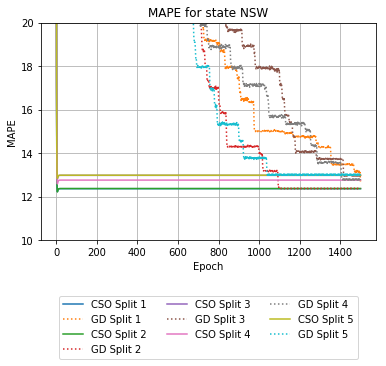

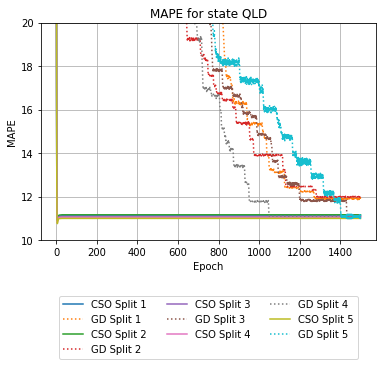

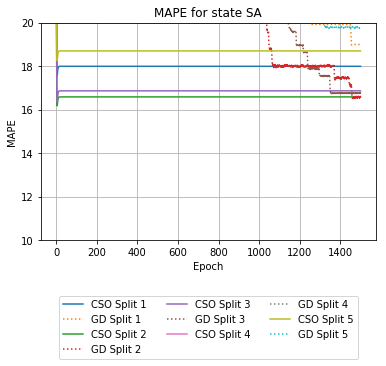

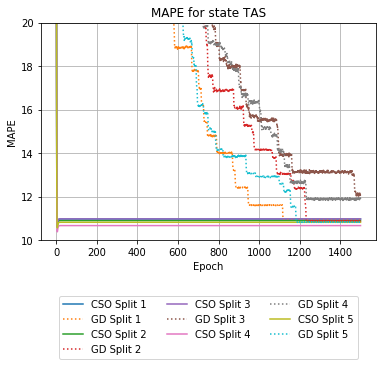

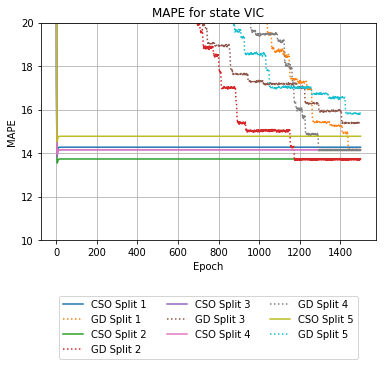

In [30]:
plot()